Import Libraries

In [2]:
# Install libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [3]:
# Load data
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

fake_news.head(10)

# Add label column (1 for fake, 0 for true)
fake_news['label'] = 1
true_news['label'] = 0

# Combine the datasets
news_data = pd.concat([fake_news[['title', 'text', 'label']], true_news[['title', 'text', 'label']]])

# Shuffle the data
news_data = news_data.sample(frac=1).reset_index(drop=True)

In [4]:
# Drop duplicates
news_data = news_data.drop_duplicates()
print(news_data)

                                                   title  \
0      VA WHISTLEBLOWER TELLS OF “LAWLESSNESS AND CHA...   
1      BREAKING: DNC CHARWOMAN Shouted Down In Chaos ...   
2      Trump to roll back use of climate change in po...   
3      BREAKING: 19 Yr Old Ethiopian Immigrant Senten...   
4      BREAKING: DEATH FOR WELFARE LEECH AND BOSTON J...   
...                                                  ...   
44891   Trump Will Spend More Taxpayer Money On Vacat...   
44893  Catalan leader says not enough guarantees from...   
44894  GAO to examine panel on foreign investment in ...   
44895  Michigan governor tells credit rating agencies...   
44897   Trump Just Took To Twitter To Proudly Defend ...   

                                                    text  label  
0      This is nothing short of outrageous! Billions ...      1  
1      DNC Chairwoman shouted down during opening rem...      1  
2      WASHINGTON (Reuters) - U.S. President Donald T...      0  
3      The moth

In [5]:
# Create a TF-IDF vectorizer for the 'text' column
tfidf_text = TfidfVectorizer(max_features=5000, stop_words='english')
text_vectors = tfidf_text.fit_transform(news_data['text'])

# Create a TF-IDF vectorizer for the 'title' column
tfidf_title = TfidfVectorizer(max_features=2000, stop_words='english')
title_vectors = tfidf_title.fit_transform(news_data['title'])

In [6]:
import numpy as np
# Concatenate the vectors
combined_vectors = np.concatenate((title_vectors.toarray(), text_vectors.toarray()), axis=1)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(combined_vectors, rowvar=False)

# Print or further process the correlation matrix as needed
print(correlation_matrix)


[[ 1.          0.06115282  0.08485728 ... -0.00105892 -0.00102862
  -0.0029055 ]
 [ 0.06115282  1.         -0.00279731 ... -0.00354842 -0.00304946
  -0.00259833]
 [ 0.08485728 -0.00279731  1.         ...  0.00158612 -0.00241137
  -0.00205464]
 ...
 [-0.00105892 -0.00354842  0.00158612 ...  1.          0.01423131
  -0.00260634]
 [-0.00102862 -0.00304946 -0.00241137 ...  0.01423131  1.
  -0.00223985]
 [-0.0029055  -0.00259833 -0.00205464 ... -0.00260634 -0.00223985
   1.        ]]


In [9]:
# ===== DATA PREPROCESSING =====

# 1. Handle missing values
print("Missing values before cleaning:")
print(news_data.isnull().sum())

# Fill missing values
news_data['title'] = news_data['title'].fillna('')
news_data['text'] = news_data['text'].fillna('')

# 2. Text cleaning function
def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply text cleaning
print("\nCleaning text data...")
news_data['title_cleaned'] = news_data['title'].apply(clean_text)
news_data['text_cleaned'] = news_data['text'].apply(clean_text)

# 3. Remove empty entries after cleaning
print(f"\nDataset size before removing empty entries: {len(news_data)}")
news_data = news_data[(news_data['title_cleaned'] != '') | (news_data['text_cleaned'] != '')]
print(f"Dataset size after removing empty entries: {len(news_data)}")

# 4. Feature engineering - combine title and text
news_data['combined_text'] = news_data['title_cleaned'] + ' ' + news_data['text_cleaned']

# 5. Remove very short articles (less than 50 characters)
print(f"\nDataset size before removing short articles: {len(news_data)}")
news_data = news_data[news_data['combined_text'].str.len() >= 50]
print(f"Dataset size after removing short articles: {len(news_data)}")

# 6. Check class distribution
print("\nClass distribution:")
print(news_data['label'].value_counts())
print("\nClass distribution (percentages):")
print(news_data['label'].value_counts(normalize=True) * 100)

# 7. Optional: Balance the dataset if needed
from sklearn.utils import resample

# Check if balancing is needed
class_counts = news_data['label'].value_counts()
min_class_size = class_counts.min()
max_class_size = class_counts.max()

if max_class_size / min_class_size > 1.5:  # If imbalance ratio > 1.5
    print("\nDataset is imbalanced. Balancing...")
    
    # Separate classes
    fake_news_df = news_data[news_data['label'] == 1]
    real_news_df = news_data[news_data['label'] == 0]
    
    # Downsample the majority class
    if len(fake_news_df) > len(real_news_df):
        fake_news_balanced = resample(fake_news_df, 
                                    replace=False,
                                    n_samples=len(real_news_df),
                                    random_state=42)
        news_data_balanced = pd.concat([fake_news_balanced, real_news_df])
    else:
        real_news_balanced = resample(real_news_df, 
                                    replace=False,
                                    n_samples=len(fake_news_df),
                                    random_state=42)
        news_data_balanced = pd.concat([fake_news_df, real_news_balanced])
    
    # Shuffle the balanced dataset
    news_data = news_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("Balanced class distribution:")
    print(news_data['label'].value_counts())
else:
    print("\nDataset is already balanced.")

# 8. Calculate text statistics for analysis
news_data['text_length'] = news_data['combined_text'].str.len()
news_data['word_count'] = news_data['combined_text'].str.split().str.len()

print("\nText statistics:")
print(f"Average text length: {news_data['text_length'].mean():.2f}")
print(f"Average word count: {news_data['word_count'].mean():.2f}")
print(f"Min text length: {news_data['text_length'].min()}")
print(f"Max text length: {news_data['text_length'].max()}")

# 9. Final dataset info
print(f"\nFinal preprocessed dataset shape: {news_data.shape}")
print("\nFinal dataset info:")
print(news_data.info())

# Display sample of cleaned data
print("\nSample of preprocessed data:")
print(news_data[['title_cleaned', 'text_cleaned', 'label']].head())

Missing values before cleaning:
title            0
text             0
label            0
title_cleaned    0
text_cleaned     0
combined_text    0
text_length      0
word_count       0
dtype: int64

Cleaning text data...

Dataset size before removing empty entries: 39087
Dataset size after removing empty entries: 39087

Dataset size before removing short articles: 39087
Dataset size after removing short articles: 39087

Class distribution:
label
0    21196
1    17891
Name: count, dtype: int64

Class distribution (percentages):
label
0    54.227748
1    45.772252
Name: proportion, dtype: float64

Dataset is already balanced.

Dataset size before removing empty entries: 39087
Dataset size after removing empty entries: 39087

Dataset size before removing short articles: 39087
Dataset size after removing short articles: 39087

Class distribution:
label
0    21196
1    17891
Name: count, dtype: int64

Class distribution (percentages):
label
0    54.227748
1    45.772252
Name: proportion, dty

Text vectors shape: (39087, 5000)
Title vectors shape: (39087, 2000)
Combined vectors shape: (39087, 7000)
Training set size: 31269
Test set size: 7818
Training set class distribution: [16956 14313]
Test set class distribution: [4240 3578]

Training the model...

=== MODEL PERFORMANCE ===
Accuracy: 0.9942

Confusion Matrix:
[[4226   14]
 [  31 3547]]

Classification Report:
              precision    recall  f1-score   support

   Real News       0.99      1.00      0.99      4240
   Fake News       1.00      0.99      0.99      3578

    accuracy                           0.99      7818
   macro avg       0.99      0.99      0.99      7818
weighted avg       0.99      0.99      0.99      7818


Additional Metrics:
Precision: 0.9961
Recall: 0.9913
F1-Score: 0.9937
ROC-AUC: 0.9997

=== MODEL PERFORMANCE ===
Accuracy: 0.9942

Confusion Matrix:
[[4226   14]
 [  31 3547]]

Classification Report:
              precision    recall  f1-score   support

   Real News       0.99      1.00      0

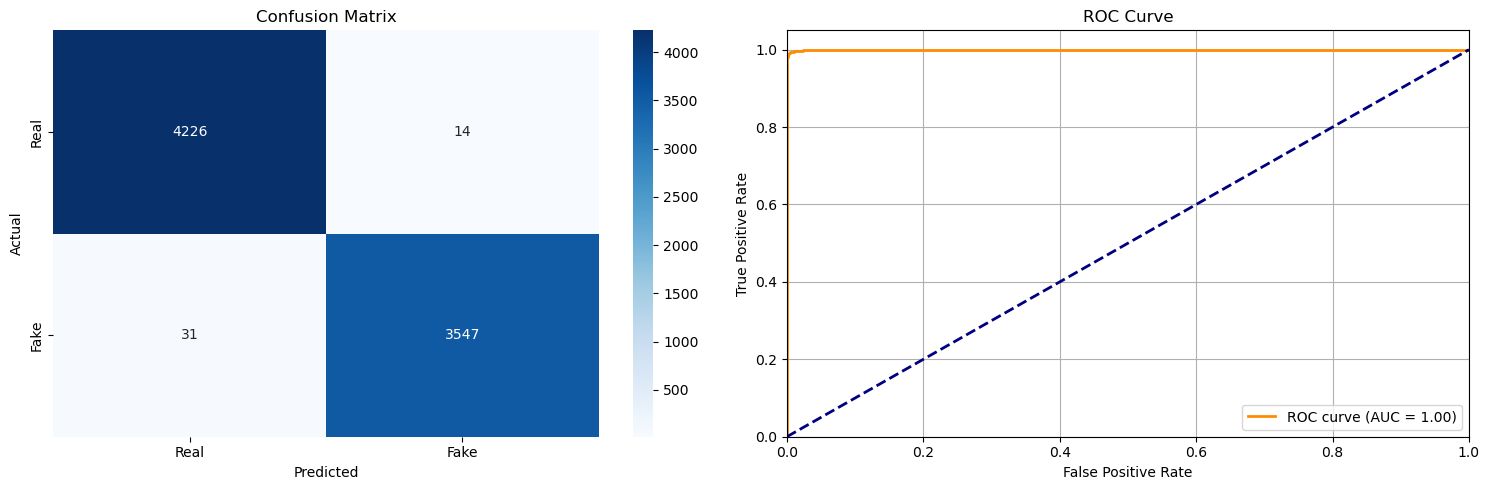


=== MODEL TRAINING COMPLETED ===


In [10]:
import numpy as np
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

# ===== VECTORIZATION WITH CLEANED DATA =====
tfidf_text = TfidfVectorizer(
    max_features=5000, 
    stop_words='english',
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8,  # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2)  # Use both unigrams and bigrams
)

tfidf_title = TfidfVectorizer(
    max_features=2000, 
    stop_words='english',
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

# Use cleaned text data for vectorization
text_vectors = tfidf_text.fit_transform(news_data['text_cleaned'])
title_vectors = tfidf_title.fit_transform(news_data['title_cleaned'])

print(f"Text vectors shape: {text_vectors.shape}")
print(f"Title vectors shape: {title_vectors.shape}")

# ===== FEATURE COMBINATION =====

# Combine the text and title vectors (using sparse matrices for efficiency)
combined_vectors = hstack([text_vectors, title_vectors])

print(f"Combined vectors shape: {combined_vectors.shape}")

# ===== TRAIN-TEST SPLIT =====

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_vectors, 
    news_data['label'], 
    test_size=0.2, 
    random_state=42,
    stratify=news_data['label']  # Ensure balanced split
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

# ===== MODEL TRAINING =====

# Train a Logistic Regression model
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0,  
    solver='liblinear'  
)

print("\nTraining the model...")
model.fit(X_train, y_train)

# ===== MODEL EVALUATION =====

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC curve

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\n=== MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real News', 'Fake News']))

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# ===== VISUALIZATION =====

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n=== MODEL TRAINING COMPLETED ===")


In [17]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import hstack

# Note: We're using the model and vectorizers that were trained in the previous cells
# No need to load from files since they're already in memory

print("Using the freshly trained model and vectorizers!")

# ===== PREDICTION FUNCTION =====

def predict_news(title, text):
    """Predict if news is real or fake using the trained model"""
    # Clean the input text using the function from preprocessing cell
    title_cleaned = clean_text(title)
    text_cleaned = clean_text(text)
    
    # Transform using the trained vectorizers
    title_vector = tfidf_title.transform([title_cleaned])
    text_vector = tfidf_text.transform([text_cleaned])
    
    # Combine vectors (same order as training: text first, then title)
    combined_vector = hstack([text_vector, title_vector])
    
    # Make prediction
    prediction = model.predict(combined_vector)[0]
    probability = model.predict_proba(combined_vector)[0]
    
    # Get confidence scores
    real_confidence = probability[0] * 100
    fake_confidence = probability[1] * 100
    
    result = 'Real' if prediction == 0 else 'Fake'
    
    return {
        'prediction': result,
        'real_confidence': real_confidence,
        'fake_confidence': fake_confidence
    }

# ===== TEST WITH SAMPLE DATA =====

# Create test data with various news samples
test_samples = [
    {
        'title': 'Watch: Is This Proof Trump Is Unfit for Service?',
        'text': 'New questions are being asked about President Donald Trump after he slurred his words during a speech. This could be due to fatigue, dry mouth, or more serious health issues. Some experts are questioning his mental stability and ability to lead.'
    },
    {
        'title': 'U.S. appeals court rejects challenge to Trump voter fraud panel',
        'text': 'Reuters - A U.S. appeals court in Washington on Tuesday upheld a lower court decision to allow President Donald Trump commission investigating voter fraud to request data on voter rolls from U.S. states. The Electronic Privacy Information Center filed the lawsuit but did not have legal standing.'
    },
    {
        'title': 'Scientists Discover New Species of Dinosaur in Argentina',
        'text': 'Paleontologists working in Argentina have discovered fossils of a previously unknown species of dinosaur that lived approximately 90 million years ago. The new species, named Meraxes gigas, was a large carnivorous dinosaur with tiny arms similar to those of Tyrannosaurus rex.'
    },
    {
        'title': 'Breaking: Aliens Land in Central Park, Demand Pizza',
        'text': 'In a shocking turn of events, extraterrestrial beings have reportedly landed their spaceship in Central Park and are demanding the finest New York pizza. Witnesses claim the aliens spoke perfect English and complained about the lack of proper toppings on other planets.'
    },
    {
        'title': 'COVID-19 Vaccine Shows 95% Effectiveness in Clinical Trials',
        'text': 'Pharmaceutical company announces that their COVID-19 vaccine candidate has shown 95% effectiveness in preventing the disease in large-scale clinical trials. The results were published in a peer-reviewed medical journal and verified by independent researchers.'
    }
]

# Test predictions on sample data
print("\n" + "="*60)
print("TESTING FAKE NEWS DETECTOR")
print("="*60)

for i, sample in enumerate(test_samples, 1):
    print(f"\nTest Sample {i}")
    print(f"Title: {sample['title']}")
    print(f"Text: {sample['text'][:150]}...")
    
    result = predict_news(sample['title'], sample['text'])
    
    print(f"\nPrediction: {result['prediction']}")
    print(f"Real News Confidence: {result['real_confidence']:.2f}%")
    print(f"Fake News Confidence: {result['fake_confidence']:.2f}%")
    print("-" * 50)


Using the freshly trained model and vectorizers!

TESTING FAKE NEWS DETECTOR

Test Sample 1
Title: Watch: Is This Proof Trump Is Unfit for Service?
Text: New questions are being asked about President Donald Trump after he slurred his words during a speech. This could be due to fatigue, dry mouth, or mor...

Prediction: Fake
Real News Confidence: 16.97%
Fake News Confidence: 83.03%
--------------------------------------------------

Test Sample 2
Title: U.S. appeals court rejects challenge to Trump voter fraud panel
Text: Reuters - A U.S. appeals court in Washington on Tuesday upheld a lower court decision to allow President Donald Trump commission investigating voter f...

Prediction: Real
Real News Confidence: 96.22%
Fake News Confidence: 3.78%
--------------------------------------------------

Test Sample 3
Title: Scientists Discover New Species of Dinosaur in Argentina
Text: Paleontologists working in Argentina have discovered fossils of a previously unknown species of dinosaur tha